# Predicting Car Insurance Claims — EDA, Feature Engineering, Modeling

This notebook walks through:
- Data loading and schema overview
- Cleaning and exploratory analysis (correlations, high-cardinality handling)
- Train/test split (leakage-aware)
- Feature engineering:
  - Outlier handling for `vehicle_age`
  - Target encoding for high-cardinality `region_code`
  - One-Hot Encoding (OHE) for remaining categoricals
- Baseline model (Logistic Regression)
- Non-linear models (Random Forest, XGBoost)
- Threshold selection on the Precision–Recall curve
- Final model training on full data and artifact saving


In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency
import scipy.stats as ss
from sklearn.metrics import (
    log_loss, roc_auc_score, accuracy_score, average_precision_score,
    confusion_matrix, classification_report, precision_score, recall_score, f1_score, 
    precision_recall_curve
)
from sklearn.ensemble import RandomForestClassifier
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Data loading and overview
- Load raw data from `insurance_claims.csv`.
- Inspect schema and class balance (`claim_status` is highly imbalanced).


In [90]:
insurance_df = pd.read_csv('insurance_claims.csv')
insurance_df.head(5)

,policy_id,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status
0,POL045360,9.3,1.2,41,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
1,POL016745,8.2,1.8,35,C2,27003,C1,M9,Diesel,200Nm@1750rpm,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,4,0
2,POL007194,9.5,0.2,44,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
3,POL018146,5.2,0.4,44,C10,73430,A,M1,CNG,60Nm@3500rpm,...,No,No,No,Yes,No,No,No,Yes,0,0
4,POL049011,10.1,1.0,56,C13,5410,B2,M5,Diesel,200Nm@3000rpm,...,No,Yes,Yes,Yes,No,No,Yes,Yes,5,0


In [91]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   subscription_length               58592 non-null  float64
 2   vehicle_age                       58592 non-null  float64
 3   customer_age                      58592 non-null  int64  
 4   region_code                       58592 non-null  object 
 5   region_density                    58592 non-null  int64  
 6   segment                           58592 non-null  object 
 7   model                             58592 non-null  object 
 8   fuel_type                         58592 non-null  object 
 9   max_torque                        58592 non-null  object 
 10  max_power                         58592 non-null  object 
 11  engine_type                       58592 non-null  object 
 12  airb

# EDA

### Column pruning (initial)
Drop known identifiers and accessories that are not predictive for claims (policy id, rear-window utilities, etc.).


In [92]:
# Exploring target variable distribution
print(insurance_df['claim_status'].value_counts())

claim_status
0    54844
1     3748
Name: count, dtype: int64


In [93]:
# Dropping irrelevant columns
drop_cols = [
    'policy_id',
    'model',
    'turning_radius',
    'length',
    'width',
    'is_rear_window_wiper',
    'is_rear_window_washer',
    'is_rear_window_defogger',
    'is_day_night_rear_view_mirror',
    'is_speed_alert'
]
insurance_df.drop(columns=drop_cols, inplace=True)

In [94]:

insurance_df.describe()

,subscription_length,vehicle_age,customer_age,region_density,airbags,displacement,cylinder,gross_weight,ncap_rating,claim_status
count,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000
mean,6.111688,1.388473,44.823935,18826.858667,3.137066,1162.355851,3.626963,1385.276813,1.759950,0.063968
std,4.142790,1.134413,6.935604,17660.174792,1.832641,266.304786,0.483616,212.423085,1.389576,0.244698
min,0.000000,0.000000,35.000000,290.000000,1.000000,796.000000,3.000000,1051.000000,0.000000,0.000000
25%,2.100000,0.400000,39.000000,6112.000000,2.000000,796.000000,3.000000,1185.000000,0.000000,0.000000
50%,5.700000,1.200000,44.000000,8794.000000,2.000000,1197.000000,4.000000,1335.000000,2.000000,0.000000
75%,10.400000,2.200000,49.000000,27003.000000,6.000000,1493.000000,4.000000,1510.000000,3.000000,0.000000
max,14.000000,20.000000,75.000000,73430.000000,6.000000,1498.000000,4.000000,1720.000000,5.000000,1.000000


### Outlier handling for `vehicle_age`
Compute Tukey upper bound (Q3 + 1.5×IQR) and filter extreme ages to stabilize downstream models.


In [95]:
# [insurance_df['vehicle_age']]
q3 = np.percentile(insurance_df['vehicle_age'], 75)
q1 = np.percentile(insurance_df['vehicle_age'], 25)

iqr = q3 - q1
upper = q3 + 1.5*iqr
print(upper)

filtered = insurance_df[insurance_df['vehicle_age'] > upper]
print(filtered['vehicle_age'].count())

4.9
269


### Type casting
Cast string/object columns to `category` so that encoding recognizes them. This stage is still pre-split; actual encoding is performed after the train/test split to avoid leakage.


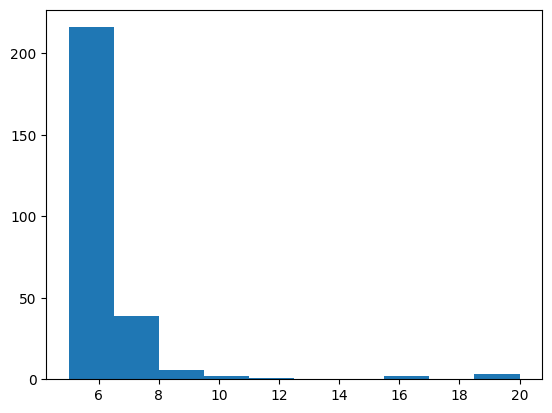

In [96]:
plt.hist(filtered['vehicle_age'], bins=10)
plt.show()

## Correlation analysis
- Compute Cramér's V for categoricals and Pearson for numericals.
- Identify near-deterministic relationships (e.g., equipment flags vs segment/engine groups).
- Use findings to prune redundant features in the next step.


In [97]:
insurance_df = insurance_df[insurance_df['vehicle_age'] <= upper]
insurance_df.describe()

,subscription_length,vehicle_age,customer_age,region_density,airbags,displacement,cylinder,gross_weight,ncap_rating,claim_status
count,58323.000000,58323.000000,58323.000000,58323.00000,58323.000000,58323.000000,58323.000000,58323.000000,58323.000000,58323.000000
mean,6.104113,1.366349,44.813710,18834.28992,3.134578,1161.652024,3.625825,1384.764261,1.756237,0.064108
std,4.141997,1.080884,6.927895,17656.65758,1.831480,266.420965,0.483913,212.378725,1.389479,0.244948
min,0.000000,0.000000,35.000000,290.00000,1.000000,796.000000,3.000000,1051.000000,0.000000,0.000000
25%,2.100000,0.400000,39.000000,6112.00000,2.000000,796.000000,3.000000,1185.000000,0.000000,0.000000
50%,5.700000,1.200000,44.000000,8794.00000,2.000000,1197.000000,4.000000,1335.000000,2.000000,0.000000
75%,10.400000,2.200000,49.000000,27003.00000,6.000000,1493.000000,4.000000,1510.000000,3.000000,0.000000
max,14.000000,4.800000,75.000000,73430.00000,6.000000,1498.000000,4.000000,1720.000000,5.000000,1.000000


In [98]:
# dropping max_power and setting max_torque as category
insurance_df.drop(columns=['max_power'], inplace=True)
insurance_df['max_torque'] = insurance_df['max_torque'].astype('category')
insurance_df['max_torque'].unique()

['250Nm@2750rpm', '200Nm@1750rpm', '60Nm@3500rpm', '200Nm@3000rpm', '113Nm@4400rpm', '82.1Nm@3400rpm', '91Nm@4250rpm', '85Nm@3000rpm', '170Nm@4000rpm']
Categories (9, object): ['113Nm@4400rpm', '170Nm@4000rpm', '200Nm@1750rpm', '200Nm@3000rpm', ..., '60Nm@3500rpm', '82.1Nm@3400rpm', '85Nm@3000rpm', '91Nm@4250rpm']

### Correlation-driven pruning
Drop highly redundant/near-deterministic features (identified above) to reduce dimensionality and improve precision without losing signal.


In [99]:
insurance_df['region_code'] = insurance_df['region_code'].astype('category')
insurance_df['segment'] = insurance_df['segment'].astype('category')
insurance_df['airbags'] = insurance_df['airbags'].astype('category')

insurance_df.columns

for col in insurance_df.columns:
    if col[:2] == 'is':
        insurance_df[col] = insurance_df[col].astype('category')
    if col[-4:] == 'type':
        insurance_df[col] = insurance_df[col].astype('category')


## Train/test split and leakage-aware encoding
- Split the dataset (stratified by `claim_status`).
- High-cardinality `region_code`: cross-fitted target encoding (smoothed mean claim rate by region).
- Keep `region_code` as numeric `region_code_te`
- This prevents leakage and avoids a wide, sparse OHE matrix for regions.


In [100]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58323 entries, 0 to 58591
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   subscription_length               58323 non-null  float64 
 1   vehicle_age                       58323 non-null  float64 
 2   customer_age                      58323 non-null  int64   
 3   region_code                       58323 non-null  category
 4   region_density                    58323 non-null  int64   
 5   segment                           58323 non-null  category
 6   fuel_type                         58323 non-null  category
 7   max_torque                        58323 non-null  category
 8   engine_type                       58323 non-null  category
 9   airbags                           58323 non-null  category
 10  is_esc                            58323 non-null  category
 11  is_adjustable_steering            58323 non-null  category


### One-Hot Encoding (remaining categoricals)
Fit `OneHotEncoder` on train-only for the remaining categorical variables. Transform both train and test, then join with numeric columns and `region_code_te`.


In [101]:
# count the categories in all categorical columns and sum them
categorical_cols = insurance_df.select_dtypes(include=['category']).columns
categorical_counts = {}

for col in categorical_cols:
    unique_counts = insurance_df[col].nunique()
    categorical_counts[col] = unique_counts

total_categories = sum(categorical_counts.values())
print(f"Total number of categories in all categorical columns: {total_categories}")

# count the number of non categorical columns and add to the total number of categories
total_categories += len(insurance_df.columns) - len(categorical_cols)
print(total_categories)

Total number of categories in all categorical columns: 85
94


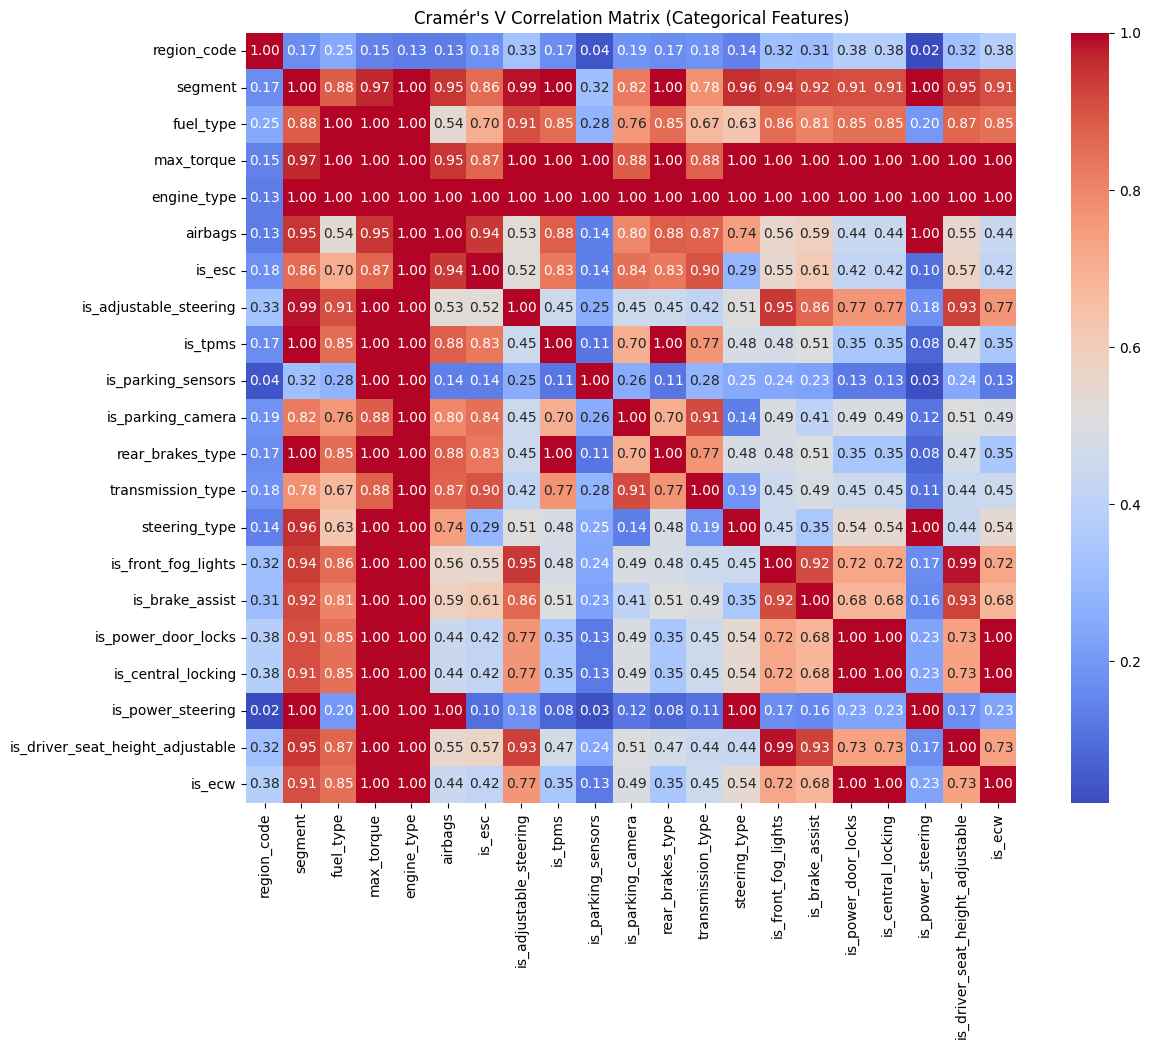

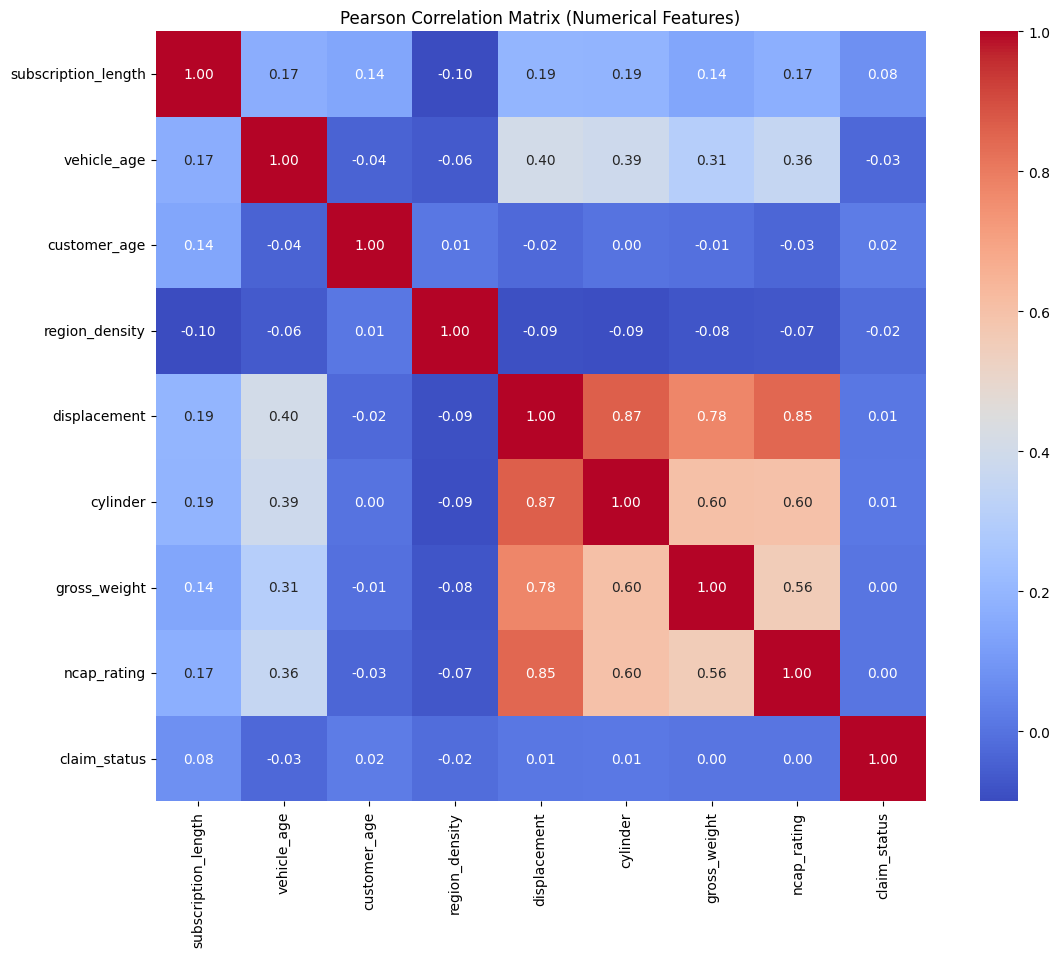

In [102]:
# Select categorical and numerical columns
categorical_cols = insurance_df.select_dtypes(include='category').columns
numerical_cols = insurance_df.select_dtypes(include=['int64', 'float64']).columns

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Calculate Cramér's V matrix for categorical columns
cramers_matrix = pd.DataFrame(np.zeros((len(categorical_cols), len(categorical_cols))), 
                              index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 == col2:
            cramers_matrix.loc[col1, col2] = 1.0
        else:
            cramers_matrix.loc[col1, col2] = cramers_v(insurance_df[col1], insurance_df[col2])

plt.figure(figsize=(14, 10))
sns.heatmap(cramers_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Cramér\'s V Correlation Matrix (Categorical Features)')
plt.show()

# Pearson correlation for numerical columns
plt.figure(figsize=(14, 10))
corr_matrix = insurance_df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Pearson Correlation Matrix (Numerical Features)')
plt.show()



In [103]:
# Find pairs of numerical features with Pearson correlation above 0.8 (absolute value)
high_corr_pairs = []
corr_matrix = insurance_df[numerical_cols].corr().abs()

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        col1 = corr_matrix.columns[i]
        col2 = corr_matrix.columns[j]
        corr_val = corr_matrix.iloc[i, j]
        if corr_val > 0.8:
            high_corr_pairs.append((col1, col2, corr_val))

print("Pairs of numerical features with Pearson correlation above 0.8:")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.2f}")

# For categorical features, find pairs with Cramér's V above 0.8 and not the same feature
high_cramersv_pairs = []
for i in range(len(cramers_matrix.columns)):
    for j in range(i+1, len(cramers_matrix.columns)):
        col1 = cramers_matrix.columns[i]
        col2 = cramers_matrix.columns[j]
        val = cramers_matrix.iloc[i, j]
        if val > 0.8:
            high_cramersv_pairs.append((col1, col2, val))

print("\nPairs of categorical features with Cramér's V above 0.8:")
for pair in high_cramersv_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.2f}")
    

Pairs of numerical features with Pearson correlation above 0.8:
displacement - cylinder: 0.87
displacement - ncap_rating: 0.85

Pairs of categorical features with Cramér's V above 0.8:
segment - fuel_type: 0.88
segment - max_torque: 0.97
segment - engine_type: 1.00
segment - airbags: 0.95
segment - is_esc: 0.86
segment - is_adjustable_steering: 0.99
segment - is_tpms: 1.00
segment - is_parking_camera: 0.82
segment - rear_brakes_type: 1.00
segment - steering_type: 0.96
segment - is_front_fog_lights: 0.94
segment - is_brake_assist: 0.92
segment - is_power_door_locks: 0.91
segment - is_central_locking: 0.91
segment - is_power_steering: 1.00
segment - is_driver_seat_height_adjustable: 0.95
segment - is_ecw: 0.91
fuel_type - max_torque: 1.00
fuel_type - engine_type: 1.00
fuel_type - is_adjustable_steering: 0.91
fuel_type - is_tpms: 0.85
fuel_type - rear_brakes_type: 0.85
fuel_type - is_front_fog_lights: 0.86
fuel_type - is_brake_assist: 0.81
fuel_type - is_power_door_locks: 0.85
fuel_type -

In [104]:
drop_cols = [
    # numeric redundancy
    'cylinder', 'displacement',
    # categorical redundancy (determined by segment/fuel_type/engine_type)
    'engine_type',            # keep fuel_type instead
    'max_torque',             # drop if not parsed to numeric
    'is_power_steering', 'is_power_door_locks', 'is_central_locking', 'is_ecw',
    'is_tpms', 'is_adjustable_steering', 'is_parking_sensors', 'is_parking_camera',
    'rear_brakes_type', 'steering_type', 'is_front_fog_lights', 'is_brake_assist',
    'is_driver_seat_height_adjustable', 'is_esc', 'segment', 'airbags'
]
to_drop = [c for c in drop_cols if c in insurance_df.columns]
insurance_df = insurance_df.drop(columns=to_drop)

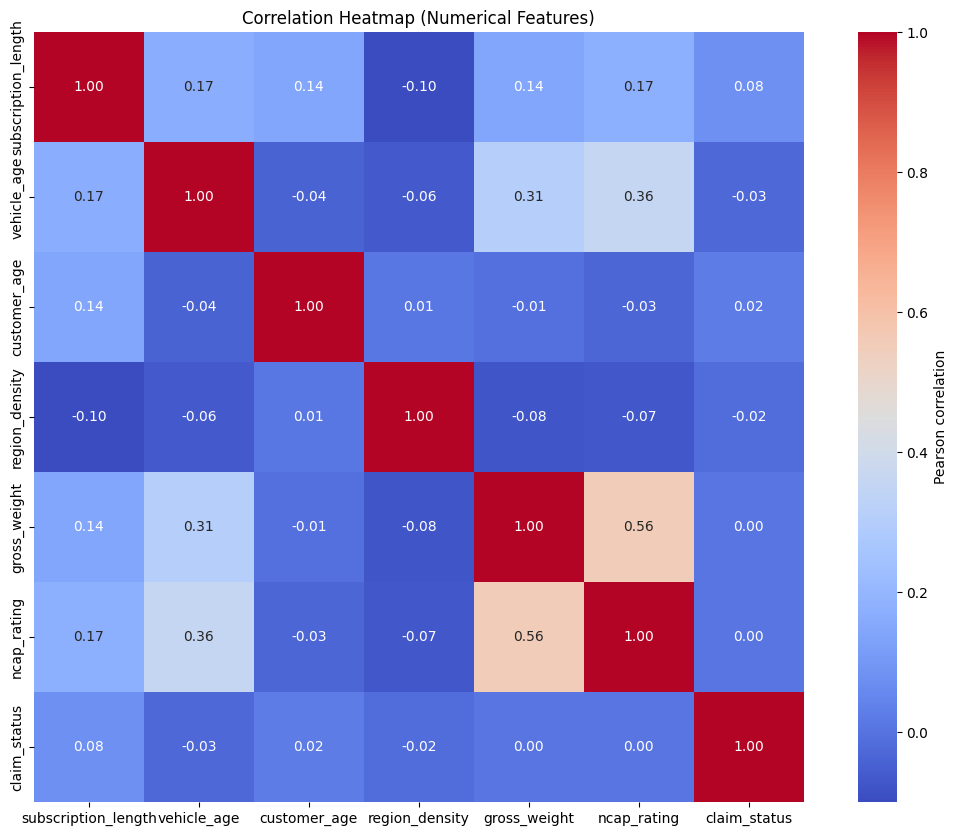

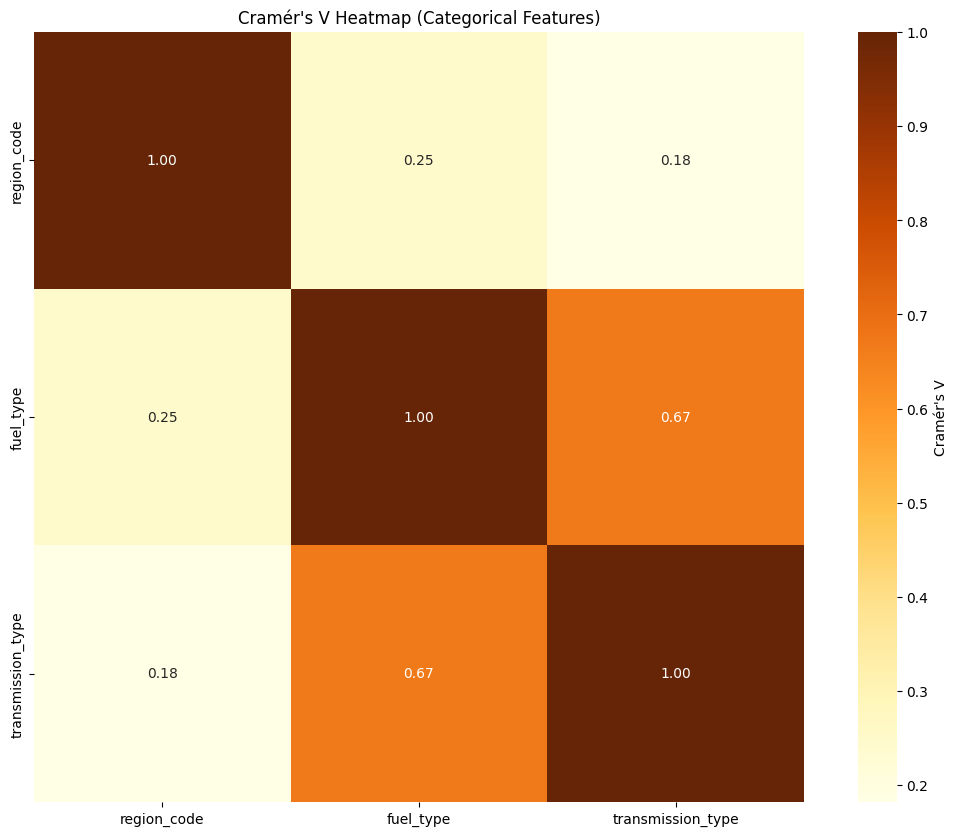

In [105]:
# Correlation heatmap for numerical features
plt.figure(figsize=(14, 10))
sns.heatmap(
    insurance_df.select_dtypes(include=[float, int]).corr(), 
    annot=True, fmt=".2f", cmap="coolwarm", square=True, 
    cbar_kws={'label': 'Pearson correlation'}
)
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

# Cramér's V heatmap for categorical features
def cramers_v(cat1, cat2):
    confusion_matrix = pd.crosstab(cat1, cat2)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cat_cols = [col for col in insurance_df.columns if str(insurance_df[col].dtype) == 'category']
if len(cat_cols) > 1:
    cramers_matrix = pd.DataFrame(
        np.eye(len(cat_cols)),
        index=cat_cols, columns=cat_cols
    )
    for i, col1 in enumerate(cat_cols):
        for j, col2 in enumerate(cat_cols):
            if i < j:
                val = cramers_v(insurance_df[col1], insurance_df[col2])
                cramers_matrix.loc[col1, col2] = val
                cramers_matrix.loc[col2, col1] = val
    plt.figure(figsize=(14, 10))
    sns.heatmap(cramers_matrix, annot=True, fmt=".2f", cmap="YlOrBr", square=True, 
                cbar_kws={'label': "Cramér's V"})
    plt.title("Cramér's V Heatmap (Categorical Features)")
    plt.show()
else:
    print("Not enough categorical features to show Cramér's V heatmap.")

In [106]:
# Train/test split BEFORE encoding
df = insurance_df.copy()
y = df['claim_status']
X = df.drop(columns=['claim_status'])

X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

def target_encode_crossfit(X, y, col, n_splits=5, smoothing=50):
    X = X.copy()
    global_mean = float(y.mean())
    te_col = np.zeros(len(X), dtype=float)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for tr_idx, va_idx in skf.split(X, y):
        df_tr = pd.DataFrame({
            col: X.iloc[tr_idx][col].astype('object').values,
            'y': y.iloc[tr_idx].values
        })
        stats = df_tr.groupby(col)['y'].agg(['mean','count'])
        score = (stats['count'] * stats['mean'] + smoothing * global_mean) / (stats['count'] + smoothing)

        mapped = X.iloc[va_idx][col].astype('object').map(score)
        mapped = mapped.astype(float).fillna(global_mean).to_numpy()
        te_col[va_idx] = mapped

    # mapping for inference (full train)
    df_full = pd.DataFrame({col: X[col].astype('object').values, 'y': y.values})
    stats_full = df_full.groupby(col)['y'].agg(['mean','count'])
    score_full = (stats_full['count'] * stats_full['mean'] + smoothing * global_mean) / (stats_full['count'] + smoothing)
    return te_col, score_full, global_mean

# Cross-fitted TE on train; map to test using full-train map
te_train, te_map, te_global = target_encode_crossfit(X_train_df, y_train, 'region_code', n_splits=5, smoothing=50)
X_train_df['region_code_te'] = te_train
X_test_df['region_code_te']  = (
    X_test_df['region_code'].astype('object').map(te_map).astype(float).fillna(te_global).values
)

# Drop raw region_code (do NOT OHE it)
X_train_df = X_train_df.drop(columns=['region_code'])
X_test_df  = X_test_df.drop(columns=['region_code'])

In [107]:
from sklearn.preprocessing import OneHotEncoder

# OHE all remaining categoricals except region_code (already dropped)
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

cat_cols_train = X_train_df.select_dtypes(include='category').columns
cat_cols_test  = X_test_df.select_dtypes(include='category').columns
assert set(cat_cols_train) == set(cat_cols_test)

# Fit on train
encoded_train = ohe.fit_transform(X_train_df[cat_cols_train])
encoded_test  = ohe.transform(X_test_df[cat_cols_test])

train_ohe = pd.DataFrame(encoded_train, columns=ohe.get_feature_names_out(cat_cols_train), index=X_train_df.index)
test_ohe  = pd.DataFrame(encoded_test,  columns=ohe.get_feature_names_out(cat_cols_test),  index=X_test_df.index)

X_train_df = pd.concat([X_train_df.drop(columns=cat_cols_train), train_ohe], axis=1)
X_test_df  = pd.concat([X_test_df.drop(columns=cat_cols_test),  test_ohe], axis=1)

# Final matrices
X_train = X_train_df.values
X_test  = X_test_df.values

## Baseline model — Logistic Regression
Train a linear baseline with `class_weight='balanced'` to counteract class imbalance. Report log loss, ROC-AUC (ranking), and the confusion matrix at the default threshold (0.5).


In [108]:
logreg = LogisticRegression(
    class_weight='balanced',  # Counteract imbalance
    max_iter=1000, 
    solver='lbfgs'
)
logreg.fit(X_train, y_train)

# Predict and evaluate
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
y_pred = logreg.predict(X_test)

print(f"Log Loss: {log_loss(y_test, y_pred_proba):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

Log Loss: 0.6745
ROC AUC Score: 0.6172
Accuracy: 0.5590
Classification Report:
              precision    recall  f1-score   support

           0     0.9525    0.5566    0.7026     10917
           1     0.0842    0.5949    0.1475       748

    accuracy                         0.5590     11665
   macro avg     0.5183    0.5757    0.4250     11665
weighted avg     0.8968    0.5590    0.6670     11665



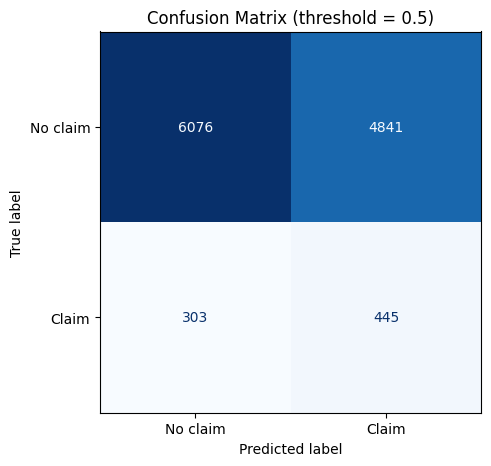

In [109]:
from sklearn.metrics import ConfusionMatrixDisplay
# Confusion Matrix plot
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No claim', 'Claim']).plot(
    ax=ax, cmap='Blues', values_format='d', colorbar=False
)
ax.set_title('Confusion Matrix (threshold = 0.5)')
plt.tight_layout()
plt.show()


## Random Forest Classifier

In [110]:
rf = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=400,
    n_jobs=-1,
    random_state=42
)

param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [None, 12, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2']
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
gs_rf = GridSearchCV(
    rf, param_grid,
    scoring='average_precision',
    cv=cv, n_jobs=-1, refit=True, verbose=0
)
gs_rf.fit(X_train, y_train)

best_rf = gs_rf.best_estimator_
probs_rf = best_rf.predict_proba(X_test)[:, 1]

print("RF best params:", gs_rf.best_params_)
print(f"RF ROC-AUC: {roc_auc_score(y_test, probs_rf):.3f}")
print(f"RF PR-AUC : {average_precision_score(y_test, probs_rf):.3f}")

RF best params: {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 500}
RF ROC-AUC: 0.660
RF PR-AUC : 0.109


In [111]:
# Additional evaluation for Random Forest — more metrics and thresholds
from sklearn.metrics import (
    accuracy_score, log_loss, precision_recall_curve,
    precision_score, recall_score, f1_score, confusion_matrix,
    classification_report
)
import numpy as np

# Metrics at default threshold 0.5
y_pred_rf_05 = (probs_rf >= 0.5).astype(int)
print("== RF @ 0.5 ==")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_05):.3f}")
print(f"Log Loss: {log_loss(y_test, probs_rf):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_rf_05, zero_division=0):.3f}")
print(f"Recall   : {recall_score(y_test, y_pred_rf_05):.3f}")
print(f"F1       : {f1_score(y_test, y_pred_rf_05):.3f}")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf_05))
print("Classification report:\n", classification_report(y_test, y_pred_rf_05, digits=3))

# Best F1 threshold on PR curve
prec_rf, rec_rf, thr_rf = precision_recall_curve(y_test, probs_rf)
rf_f1_vals = 2 * prec_rf[:-1] * rec_rf[:-1] / (prec_rf[:-1] + rec_rf[:-1] + 1e-12)
best_idx_rf = rf_f1_vals.argmax()
best_thr_rf = thr_rf[best_idx_rf]

y_pred_rf_f1 = (probs_rf >= best_thr_rf).astype(int)
print("\n== RF @ best F1 threshold ==")
print(f"Threshold: {best_thr_rf:.3f}  Precision: {prec_rf[best_idx_rf]:.3f}  Recall: {rec_rf[best_idx_rf]:.3f}  F1: {rf_f1_vals[best_idx_rf]:.3f}")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf_f1))

# Precision-constrained threshold (adjust as needed)
target_precision = 0.25
eligible = np.where(prec_rf[:-1] >= target_precision)[0]
if len(eligible):
    j = eligible[np.argmax(rec_rf[eligible])]
    thr_p_rf = thr_rf[j]
    y_pred_rf_p = (probs_rf >= thr_p_rf).astype(int)
    print(f"\n== RF threshold for precision >= {target_precision:.2f} ==")
    print(f"Threshold: {thr_p_rf:.3f}  Precision: {prec_rf[j]:.3f}  Recall: {rec_rf[j]:.3f}  F1: {f1_score(y_test, y_pred_rf_p):.3f}")
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf_p))
else:
    print(f"\nRF cannot reach precision >= {target_precision:.2f} with current features.")

== RF @ 0.5 ==
Accuracy: 0.730
Log Loss: 0.518
Precision: 0.112
Recall   : 0.464
F1       : 0.180
Confusion matrix:
 [[8166 2751]
 [ 401  347]]
Classification report:
               precision    recall  f1-score   support

           0      0.953     0.748     0.838     10917
           1      0.112     0.464     0.180       748

    accuracy                          0.730     11665
   macro avg      0.533     0.606     0.509     11665
weighted avg      0.899     0.730     0.796     11665


== RF @ best F1 threshold ==
Threshold: 0.503  Precision: 0.113  Recall: 0.460  F1: 0.182
Confusion matrix:
 [[8223 2694]
 [ 404  344]]

RF cannot reach precision >= 0.25 with current features.


## XGBoost Classifier (gradient boosting)
We train an XGBoost model tuned for imbalanced classification using `scale_pos_weight` and select hyperparameters by PR-AUC (average precision). After training, we report ROC-AUC/PR-AUC and evaluate multiple thresholds (0.5, best-F1, and a precision-constrained point).


In [112]:
# Train and evaluate XGBoost
from xgboost import XGBClassifier

# Class weight via scale_pos_weight
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()
spw = n_neg / max(1, n_pos)

xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=spw
)

param_grid = {
    'n_estimators': [300, 600],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'min_child_weight': [1, 5]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

gs_xgb = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='average_precision',  # PR-AUC
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0
)

gs_xgb.fit(X_train, y_train)

best_xgb = gs_xgb.best_estimator_
probs_xgb = best_xgb.predict_proba(X_test)[:, 1]


In [113]:
print("XGB best params:", gs_xgb.best_params_)
print(f"XGB ROC-AUC: {roc_auc_score(y_test, probs_xgb):.3f}")
print(f"XGB PR-AUC : {average_precision_score(y_test, probs_xgb):.3f}")

# Metrics at default threshold 0.5
y_pred_xgb_05 = (probs_xgb >= 0.5).astype(int)
print("\n== XGB @ 0.5 ==")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb_05):.3f}")
print(f"Log Loss: {log_loss(y_test, probs_xgb):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb_05, zero_division=0):.3f}")
print(f"Recall   : {recall_score(y_test, y_pred_xgb_05):.3f}")
print(f"F1       : {f1_score(y_test, y_pred_xgb_05):.3f}")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_xgb_05))
print("Classification report:\n", classification_report(y_test, y_pred_xgb_05, digits=3))

# Best F1 threshold on PR curve
prec_xgb, rec_xgb, thr_xgb = precision_recall_curve(y_test, probs_xgb)
xgb_f1_vals = 2 * prec_xgb[:-1] * rec_xgb[:-1] / (prec_xgb[:-1] + rec_xgb[:-1] + 1e-12)
best_idx_xgb = xgb_f1_vals.argmax()
best_thr_xgb = thr_xgb[best_idx_xgb]

y_pred_xgb_f1 = (probs_xgb >= best_thr_xgb).astype(int)
print("\n== XGB @ best F1 threshold ==")
print(f"Threshold: {best_thr_xgb:.3f}  Precision: {prec_xgb[best_idx_xgb]:.3f}  Recall: {rec_xgb[best_idx_xgb]:.3f}  F1: {xgb_f1_vals[best_idx_xgb]:.3f}")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_xgb_f1))

# Precision-constrained threshold (adjust as needed)
target_precision = 0.25
eligible = np.where(prec_xgb[:-1] >= target_precision)[0]
if len(eligible):
    j = eligible[np.argmax(rec_xgb[eligible])]
    thr_p_xgb = thr_xgb[j]
    y_pred_xgb_p = (probs_xgb >= thr_p_xgb).astype(int)
    print(f"\n== XGB threshold for precision >= {target_precision:.2f} ==")
    print(f"Threshold: {thr_p_xgb:.3f}  Precision: {prec_xgb[j]:.3f}  Recall: {rec_xgb[j]:.3f}  F1: {f1_score(y_test, y_pred_xgb_p):.3f}")
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_xgb_p))
else:
    print(f"\nXGB cannot reach precision >= {target_precision:.2f} with current features.")

XGB best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}
XGB ROC-AUC: 0.669
XGB PR-AUC : 0.115

== XGB @ 0.5 ==
Accuracy: 0.582
Log Loss: 0.632
Precision: 0.097
Recall   : 0.663
F1       : 0.169
Confusion matrix:
 [[6290 4627]
 [ 252  496]]
Classification report:
               precision    recall  f1-score   support

           0      0.961     0.576     0.721     10917
           1      0.097     0.663     0.169       748

    accuracy                          0.582     11665
   macro avg      0.529     0.620     0.445     11665
weighted avg      0.906     0.582     0.685     11665


== XGB @ best F1 threshold ==
Threshold: 0.591  Precision: 0.122  Recall: 0.382  F1: 0.185
Confusion matrix:
 [[8858 2059]
 [ 462  286]]

== XGB threshold for precision >= 0.25 ==
Threshold: 0.739  Precision: 0.250  Recall: 0.008  F1: 0.016
Confusion matrix:
 [[10899    18]
 [  742     6]]


# Finalized Random Forest

In [114]:
# Finalize Random Forest with best params, evaluate, and save artifacts
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score, log_loss,
    precision_recall_curve, precision_score, recall_score, f1_score, confusion_matrix,
    classification_report
)
from joblib import dump
import json, time

best_params = {
    'n_estimators': 300,
    'max_depth': 12,
    'min_samples_leaf': 10,
    'max_features': 'sqrt',
    'class_weight': 'balanced',
    'n_jobs': -1,
    'random_state': 42
}

# 1) Fit on train for honest evaluation
rf_final = RandomForestClassifier(**best_params)
rf_final.fit(X_train, y_train)
probs_final = rf_final.predict_proba(X_test)[:, 1]

# Metrics at threshold 0.5
y_pred_05 = (probs_final >= 0.5).astype(int)
print("== Final RF @ 0.5 ==")
print(f"ROC-AUC: {roc_auc_score(y_test, probs_final):.3f}")
print(f"PR-AUC : {average_precision_score(y_test, probs_final):.3f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_05):.3f}")
print(f"Log Loss: {log_loss(y_test, probs_final):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_05, zero_division=0):.3f}")
print(f"Recall   : {recall_score(y_test, y_pred_05):.3f}")
print(f"F1       : {f1_score(y_test, y_pred_05):.3f}")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_05))
print("Classification report:\n", classification_report(y_test, y_pred_05, digits=3))

# Best-F1 threshold on PR curve
prec, rec, thr = precision_recall_curve(y_test, probs_final)
f1_vals = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
best_idx = f1_vals.argmax()
best_thr = thr[best_idx]

y_pred_f1 = (probs_final >= best_thr).astype(int)
print("\n== Final RF @ best F1 threshold ==")
print(f"Threshold: {best_thr:.3f}  Precision: {prec[best_idx]:.3f}  Recall: {rec[best_idx]:.3f}  F1: {f1_vals[best_idx]:.3f}")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_f1))


== Final RF @ 0.5 ==
ROC-AUC: 0.660
PR-AUC : 0.109
Accuracy: 0.732
Log Loss: 0.517
Precision: 0.112
Recall   : 0.461
F1       : 0.181
Confusion matrix:
 [[8194 2723]
 [ 403  345]]
Classification report:
               precision    recall  f1-score   support

           0      0.953     0.751     0.840     10917
           1      0.112     0.461     0.181       748

    accuracy                          0.732     11665
   macro avg      0.533     0.606     0.510     11665
weighted avg      0.899     0.732     0.798     11665


== Final RF @ best F1 threshold ==
Threshold: 0.498  Precision: 0.113  Recall: 0.473  F1: 0.183
Confusion matrix:
 [[8140 2777]
 [ 394  354]]


In [115]:
# Re-encode full dataset with train-fitted encoders and save final RF cleanly
import pandas as pd
from joblib import dump
import json, time

# Helper uses the TRAIN-FITTED objects: te_map, te_global, ohe, cat_cols_train, X_train_df

def transform_full_with_train_encoders(df_full: pd.DataFrame) -> pd.DataFrame:
    Xf = df_full.drop(columns=['claim_status']).copy()
    # 1) Target-encode region_code with train mapping
    Xf['region_code_te'] = (
        Xf['region_code'].astype('object').map(te_map).astype(float).fillna(te_global).values
    )
    Xf = Xf.drop(columns=['region_code'])
    # 2) OHE remaining categoricals using the train-fitted OHE and the same feature list
    cat_cols = list(cat_cols_train)
    encoded = ohe.transform(Xf[cat_cols])
    df_ohe = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(cat_cols), index=Xf.index)
    Xf = pd.concat([Xf.drop(columns=cat_cols), df_ohe], axis=1)
    return Xf

# Build full matrix and align to train column order
X_all_df = transform_full_with_train_encoders(insurance_df)
train_columns = list(X_train_df.columns)
X_all_df = X_all_df.reindex(columns=train_columns, fill_value=0.0)

y_all = insurance_df['claim_status'].values

rf_full = RandomForestClassifier(**best_params)
rf_full.fit(X_all_df.values, y_all)

# Save artifacts
art_prefix = "/Users/brunondibambwayeroy/Documents/AI4ALL Ignite/"
model_path = art_prefix + "rf_best_model_full.joblib"
meta_path = art_prefix + "rf_best_threshold.json"
cols_path = art_prefix + "rf_feature_columns.json"
params_path = art_prefix + "rf_training_params.json"

dump(rf_full, model_path)
json.dump({'best_f1_threshold': float(best_thr), 'generated_at': time.strftime('%Y-%m-%d %H:%M:%S')}, open(meta_path, 'w'))
json.dump(train_columns, open(cols_path, 'w'))
json.dump(best_params, open(params_path, 'w'))

print(f"Saved model to: {model_path}")
print(f"Saved threshold to: {meta_path}")
print(f"Saved feature columns to: {cols_path}")
print(f"Saved training params to: {params_path}")


Saved model to: /Users/brunondibambwayeroy/Documents/AI4ALL Ignite/rf_best_model_full.joblib
Saved threshold to: /Users/brunondibambwayeroy/Documents/AI4ALL Ignite/rf_best_threshold.json
Saved feature columns to: /Users/brunondibambwayeroy/Documents/AI4ALL Ignite/rf_feature_columns.json
Saved training params to: /Users/brunondibambwayeroy/Documents/AI4ALL Ignite/rf_training_params.json
